# Introduction to NLP

##### TP1 done by Litoux Pierre, Arsenec Charles-André, Deplagne Hugo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from string import punctuation
import functools
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# The dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset

Found cached dataset imdb (/home/coartix/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### 1. How many splits does the dataset has?
The dataset has 3 splits (training, test, unsupervised).

### 2. How big are these splits?
train -> 25000 rows  
test -> 25000 rows  
unsupervised -> 50000 rows  
A row contains a text and a value 0 or 1 corresponding respectively to a negative sentiment or a positive one.

##### We will create dataframes to manipulate the data in each splits :

In [3]:
pd.set_option('display.max_colwidth', 100)
df_train = pd.DataFrame(dataset['train'])
df_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded ...,0
1,"""I Am Curious: Yellow"" is a risible and pretentious steaming pile. It doesn't matter what one's ...",0
2,If only to avoid making this type of film in the future. This film is interesting as an experime...,0
3,"This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film in...",0
4,"Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is t...",0
...,...,...
24995,"A hit at the time but now better categorised as an Australian cult film. The humour is broad, un...",1
24996,I love this movie like no other. Another time I will try to explain its virtues to the uninitiat...,1
24997,"This film and it's sequel Barry Mckenzie holds his own, are the two greatest comedies to ever be...",1
24998,"'The Adventures Of Barry McKenzie' started life as a satirical comic strip in 'Private Eye', wri...",1


In [4]:
df_test = pd.DataFrame(dataset['test'])
df_test

,text,label
0,"I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, und...",0
1,"Worth the entertainment value of a rental, especially if you like action movies. This one featur...",0
2,its a totally average film with a few semi-alright action sequences that make the plot seem a li...,0
3,STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday ...,0
4,"First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably wi...",0
...,...,...
24995,Just got around to seeing Monster Man yesterday. It had been a long wait and after lots of antic...,1
24996,"I got this as part of a competition prize. I watched it, not really expecting much from an obvio...",1
24997,I got Monster Man in a box set of three films where I mainly wanted the other two but still had ...,1
24998,"Five minutes in, i started to feel how naff this was looking, you've got a completely unheroic h...",1


In [5]:
df_unsupervised = pd.DataFrame(dataset['unsupervised'])
df_unsupervised

,text,label
0,"This is just a precious little diamond. The play, the script are excellent. I cant compare this ...",-1
1,"When I say this is my favourite film of all time, that comment is not to be taken lightly. I pro...",-1
2,I saw this movie because I am a huge fan of the TV series of the same name starring Roy Dupuis a...,-1
3,Being that the only foreign films I usually like star a Japanese person in a rubber suit who cru...,-1
4,"After seeing Point of No Return (a great movie) and being told that the original was better, I w...",-1
...,...,...
49995,License To Kill (1989) is an inanely dismal installment to the Bond franchise that is best forgo...,-1
49996,"I love watching a James Bond. It's not very intellectual, granted, but it's fun. I know the basi...",-1
49997,"I can't decide what was the worst thing about this movie. The bad plot, terrible acting, cheesy ...",-1
49998,"UGH... As an adorer of the James Bond character, I have to call Timothy Dalton a sacrilege! And ...",-1


#### 3. What is the proportion of each class on the supervised splits?

Here is a plot counting the number of each class into train and test splits :

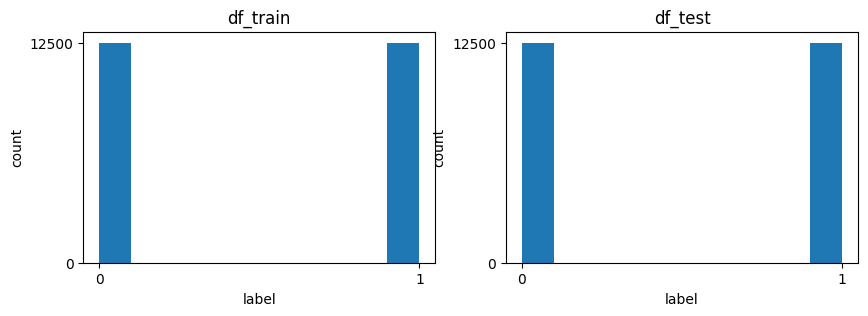

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i, df, df_str in zip([0, 1], [df_train, df_test], ['df_train', 'df_test']):
    ax[i].set_xticks([0, 1])
    ax[i].set_yticks([0, df['label'].value_counts().max()])
    ax[i].hist(df['label'])
    ax[i].set_xlabel('label')
    ax[i].set_ylabel('count')
    ax[i].set_title(df_str)

plt.show()

In [7]:
labels = df_train["label"].unique()
labels

array([0, 1])

The classes are either 0 or 1. Each classes count up for 12500 on each splits (test and train).

## Naive Bayes classifier


#### 1. Preprocessing

We will lower the text to not duplicate words that may be the same with capitals.  
Some texts contain some html like "<br \/>" or punctuations which are not necessary. <br> Let remove them except for '-' which may be useful to keep.

In [8]:
def preprocessingString(text: str) -> str:
    '''
        Preprocessing string
        Input:
            text: string
        Output:
            text: string
    '''
    text = text.lower().replace("<br />", " ")
    for punct in punctuation:
        if (not punct in str("-")):
            text = text.replace(punct, " ")
    return text

In [9]:
df_train['text'] = df_train['text'].apply(lambda text: preprocessingString(text))
df_train.head()

,text,label
0,i rented i am curious-yellow from my video store because of all the controversy that surrounded ...,0
1,i am curious yellow is a risible and pretentious steaming pile it doesn t matter what one s ...,0
2,if only to avoid making this type of film in the future this film is interesting as an experime...,0
3,this film was probably inspired by godard s masculin féminin and i urge you to see that film in...,0
4,oh brother after hearing about this ridiculous film for umpteen years all i can think of is t...,0


In [10]:
df_test['text'] = df_test['text'].apply(lambda text: preprocessingString(text))
df_test.head()

,text,label
0,i love sci-fi and am willing to put up with a lot sci-fi movies tv are usually underfunded und...,0
1,worth the entertainment value of a rental especially if you like action movies this one featur...,0
2,its a totally average film with a few semi-alright action sequences that make the plot seem a li...,0
3,star rating saturday night friday night friday morning sunday night monday ...,0
4,first off let me say if you haven t enjoyed a van damme movie since bloodsport you probably wi...,0


#### 2. Naive Bayes from Scratch

In [11]:
def trainNaiveBayes(df: pd.DataFrame, classes: list) -> tuple:
    '''
        Input:
            df: dataframe
            classes: list of classes
        Output:
            log_prior: list of log prior of each class
            loglikehood: list of log likehood of each class
            vocabulary: set of vocabulary
    '''
    log_prior = []
    loglikehood = []
    vocabulary = set(str().join((df['text'])).split(" "))
    n_doc = df.shape[0]
    
    for class_c in classes:
        n_class = df[df['label'] == class_c].shape[0]
        log_prior.append(np.log(n_class / n_doc))
        big_doc = str().join((df[df['label'] == class_c]['text'])).split(" ")
        
        d = defaultdict(int)
        for word in big_doc:
           d[word] += 1 
        sumcount_v = sum(d.values()) + len(vocabulary)
        
        loglikehood_c = {}
        for word in vocabulary:
            loglikehood_c[word] = np.log((d[word] + 1) / sumcount_v)
        loglikehood.append(loglikehood_c)
    
    return log_prior, loglikehood, vocabulary

In [12]:
logprior, loglikehood, vocabulary = trainNaiveBayes(df_train, labels)

In [13]:
def testNaiveBayes(testdoc: str, logprior: list, loglikehood: list, classes: list, vocabulary: set) -> int:
    '''
        Input:
            testdoc: string
            log_prior: list of log prior of each class
            loglikehood: list of log likehood of each class
            classes: list of classes
            vocabulary: set of vocabulary
        Output:
            class: class of testdoc
    '''
    probabilty_class = {}
    for classes_c in classes:
        probabilty_class[classes_c] = logprior[classes_c]
        for word in testdoc.split():
            if (word in vocabulary):
                probabilty_class[classes_c] += loglikehood[classes_c][word]
    return np.argmax(list(probabilty_class.values()))

In [14]:
# Testing the scratch implementation on the test set
y_pred = df_test['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_test['label']
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.8156

#### 3. Naive Bayes from Scikit-learn

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

PipelineNB = Pipeline([('vect', CountVectorizer()),
                       ('clf', MultinomialNB())])
PipelineNB.fit(df_train['text'], df_train['label'])

y_pred = PipelineNB.predict(df_test['text'])
y_true = df_test['label']
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.81432

#### 4. Accuracy report

In [16]:
# Own implementation
# Training set
y_pred = df_train['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_train['label']
print("Own implementation - Training set accuracy: ", accuracy_score(y_true, y_pred))

# Test set
y_pred = df_test['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_test['label']
print("Own implementation - Test set accuracy: ", accuracy_score(y_true, y_pred))

# Scikit-learn implementation
# Training set
y_pred = PipelineNB.predict(df_train['text'])
y_true = df_train['label']
print("Scikit-learn implementation - Training set accuracy: ", accuracy_score(y_true, y_pred))

# Test set
y_pred = PipelineNB.predict(df_test['text'])
y_true = df_test['label']
print("Scikit-learn implementation - Test set accuracy: ", accuracy_score(y_true, y_pred))

Own implementation - Training set accuracy:  0.90312
Own implementation - Test set accuracy:  0.8156
Scikit-learn implementation - Training set accuracy:  0.89768
Scikit-learn implementation - Test set accuracy:  0.81432


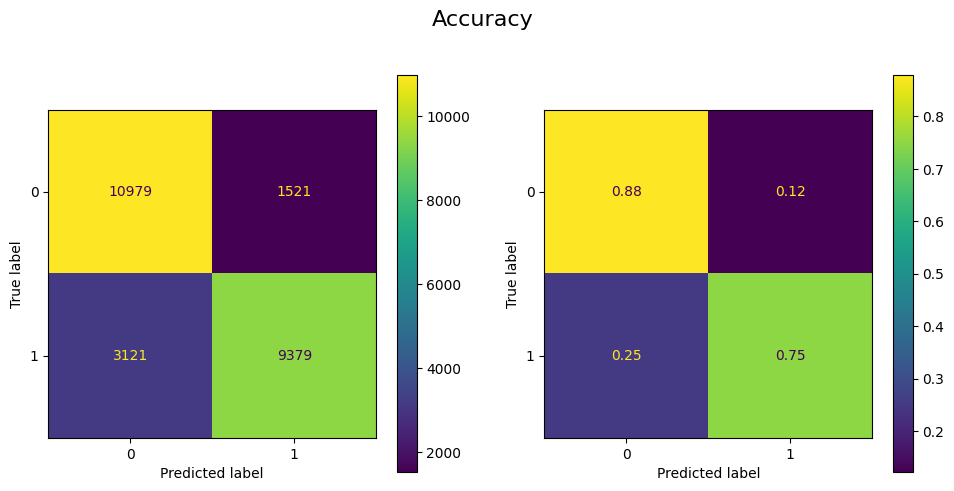

In [17]:
# Displaying the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Accuracy', fontsize=16)

for i, cm in zip([1, 2], [cm, cmn]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    ax = plt.subplot(1, 2, i)
    disp.plot(ax=ax)
    
fig.tight_layout(pad=2)
plt.show()


#### 5. Most likely, the scikit-learn implementation will give better results. Looking at the documentation, explain why it could be the case.

This could be explained because the multinomial Naive Bayes classifier is better suited for classification with discrete features.

#### 6. Why is accuracy a sufficient measure of evaluation here?

Because there is only 2 classes so on a test the prediction is either true or false. This is well represented by a proportion of valid and wrong tests.

#### 7. Using one of the implementation, take at least 2 wrongly classified example from the test set and try explaining why the model failed.

We will use our own implementation and show two texts where the implementation failed to predict the right class :

In [18]:
y_pred = df_test['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_test['label']

df_wrong_pred = df_test[y_true != y_pred]

pd.set_option('display.max_colwidth', None)
df_wrong_pred.iloc[[0, -1]]


,text,label
11,blind date columbia pictures 1934 was a decent film but i have a few issues with this film first of all i don t fault the actors in this film at all but more or less i have a problem with the script also i understand that this film was made in the 1930 s and people were looking to escape reality but the script made ann sothern s character look weak she kept going back and forth between suitors and i felt as though she should have stayed with paul kelly s character in the end he truly did care about her and her family and would have done anything for her and he did by giving her up in the end to fickle neil hamilton who in my opinion was only out for a good time paul kelly s character although a workaholic was a man of integrity and truly loved kitty ann sothern as opposed to neil hamilton while he did like her a lot i didn t see the depth of love that he had for her character the production values were great but the script could have used a little work,0
24999,i caught this movie on the sci-fi channel recently it actually turned out to be pretty decent as far as b-list horror suspense films go two guys one naive and one loud mouthed a take a road trip to stop a wedding but have the worst possible luck when a maniac in a freaky make-shift tank truck hybrid decides to play cat-and-mouse with them things are further complicated when they pick up a ridiculously whorish hitchhiker what makes this film unique is that the combination of comedy and terror actually work in this movie unlike so many others the two guys are likable enough and there are some good chase suspense scenes nice pacing and comic timing make this movie more than passable for the horror slasher buff definitely worth checking out,1


Here is two examples where the program should have return a class 0 and 1 (negative, positive).  
  
-> The first one was predicted negative and the second one positive although both predictions are false. This could be explained by the fact that each of them uses rarely used words that pushes them onto a class even though it is not representative of that specific class. Words like 'paul', 'kelly', 'kitty', 'ann', 'neil', 'hamilton', 'columbia' in the first text. And 'whorish', 'slasher', 'buff', 'sci', 'fi' on the second one.

#### 8. [BONUS] What are the top 10 most important words (features) for each class?

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/coartix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Get the most important words for each class
def getImportantWords(loglikehood, classes, vocabulary):
    '''
        Input:
            loglikehood: list of log likehood of each class
            classes: list of classes
            vocabulary: set of vocabulary
        Output:
            important_words: dictionary of important words for each class
    '''
    important_words = {}
    for classes_c in classes:
        important_words[classes_c] = sorted(loglikehood[classes_c], key=loglikehood[classes_c].get, reverse=True)[:100]
    return important_words

importantWords = getImportantWords(loglikehood, labels, vocabulary)
for classes_c in labels:
    print("Class: ", classes_c)
    print(importantWords[classes_c])
    print()

Class:  0
['', 'the', 'a', 'and', 'of', 'to', 'is', 'it', 'i', 'in', 'this', 'that', 's', 'was', 'movie', 'for', 'but', 'with', 'as', 't', 'film', 'you', 'on', 'not', 'have', 'are', 'be', 'he', 'they', 'one', 'at', 'his', 'all', 'so', 'like', 'there', 'just', 'by', 'or', 'an', 'who', 'from', 'if', 'about', 'out', 'what', 'some', 'no', 'her', 'even', 'can', 'has', 'good', 'bad', 'would', 'only', 'more', 'when', 'up', 'she', 'really', 'had', 'were', 'time', 'my', 'very', 'which', 'me', 'see', 'don', 'we', 'their', 'do', 'than', 'story', 'been', 'much', 'get', 'because', '-', 'people', 'then', 'could', 'how', 'any', 'make', 'into', 'made', 'other', 'first', 'them', 'too', 'plot', 'movies', 'acting', 'will', 'way', 'most', 'well', 'him']

Class:  1
['', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'that', 'this', 's', 'as', 'with', 'for', 'was', 'but', 'film', 'movie', 'his', 'on', 'you', 'he', 'are', 'not', 't', 'one', 'have', 'be', 'by', 'all', 'who', 'an', 'at', 'from', 'her', 

In [21]:
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

def removeStopWords(importantWords):
    '''
        Input:
            importantWords: dictionary of important words for each class
        Output:
            importantWords: dictionary of important words for each class
    '''
    for classes_c in labels:
        importantWords[classes_c] = [word for word in importantWords[classes_c] if word not in stops]
    return importantWords

importantWords = removeStopWords(importantWords)
for classes_c in labels:
    print("Class: ", classes_c)
    print(importantWords[classes_c])
    print()

Class:  0
['', 'movie', 'film', 'one', 'like', 'even', 'good', 'bad', 'would', 'really', 'time', 'see', 'story', 'much', 'get', '-', 'people', 'could', 'make', 'made', 'first', 'plot', 'movies', 'acting', 'way', 'well']

Class:  1
['', 'film', 'movie', 'one', 'like', 'good', 'story', 'great', 'time', 'see', 'well', 'also', 'really', 'would', 'even', '-', 'much', 'first', 'people', 'best', 'get', 'love', 'way', 'life', 'films', 'many', 'made', 'think']



Here are the most important words for each class that brings the decision to likely select the class it corresponds to. In class 1 we can see that the word 'love' or 'great' makes the decision favorable towards this class because it doesnt appear in the class 0.

# Stemming and Lemmatization

#### 1. Adding stemming to pretreatment

In [22]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/coartix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
import re

def stemmingPreProcessing(text):
    '''
        Input:
            text: string
        Output:
            text: string after stemming
    '''
    re_word = re.compile(r"^\w+$")
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in word_tokenize(text.lower().replace("<br />", "")) if re_word.match(word)]
    return " ".join(stemmed)

In [24]:
# Display the train dataframe after stemming
pd.set_option('display.max_colwidth', 100)
df_train = pd.DataFrame(dataset['train'])
df_train['text'] = df_train['text'].apply(lambda text: stemmingPreProcessing(text))
df_train.head()

,text,label
0,i rent i am from my video store becaus of all the controversi that surround it when it was first...,0
1,i am curious yellow is a risibl and pretenti steam pile it doe matter what one polit view are be...,0
2,if onli to avoid make this type of film in the futur this film is interest as an experi but tell...,0
3,this film was probabl inspir by godard masculin féminin and i urg you to see that film film has ...,0
4,oh brother after hear about this ridicul film for umpteen year all i can think of is that old pe...,0


In [25]:
# Display the test dataframe after stemming
df_test = pd.DataFrame(dataset['test'])
df_test['text'] = df_test['text'].apply(lambda text: stemmingPreProcessing(text))
df_test.head()

,text,label
0,i love and am will to put up with a lot are usual underfund and misunderstood i tri to like this...,0
1,worth the entertain valu of a rental especi if you like action movi this one featur the usual ca...,0
2,it a total averag film with a few action sequenc that make the plot seem a littl better and remi...,0
3,star rate saturday night friday night friday morn sunday night monday morn former new orlean hom...,0
4,first off let me say if you have enjoy a van damm movi sinc bloodsport you probabl will not like...,0


#### 2. Train and evaluate your model again with these pretreatment.

In [26]:
# Train the stemmed data
logprior, loglikehood, vocabulary = trainNaiveBayes(df_train, labels)

In [27]:
# Testing the train set
y_pred = df_train['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_train['label']
print("Own implementation (Stemming) - Training set accuracy: ", accuracy_score(y_true, y_pred))

# Testing the test set
y_pred = df_test['text'].apply(lambda text : testNaiveBayes(text, logprior, loglikehood, labels, vocabulary))
y_true = df_test['label']
print("Own implementation (Stemming) - Test set accuracy: ", accuracy_score(y_true, y_pred))


Own implementation (Stemming) - Training set accuracy:  0.8776
Own implementation (Stemming) - Test set accuracy:  0.79944


#### 3. Are the results better or worse? Try explaining why the accuracy changed.  
  
The results show the stemming process to be less effective.  
The accuracy changed because the stemming pretreatment shorten words so that we don't have multiple occurence of the same word which could take multiple forms like 'enjoy', 'enjoys', 'enjoyed', 'enjoying'. Those are all grouped and written as 'enjoy'.

In [28]:
importantWords = getImportantWords(loglikehood, labels, vocabulary)
importantWords = removeStopWords(importantWords)
for classes_c in labels:
    print("Class: ", classes_c)
    print(importantWords[classes_c])
    print()

Class:  0
['movi', 'film', 'one', 'like', 'make', 'would', 'even', 'get', 'bad', 'good', 'watch', 'time', 'charact', 'onli', 'see', 'realli', 'veri', 'could', 'look', 'stori', 'doe', 'scene', 'act', 'much', 'becaus', 'go', 'end', 'peopl', 'ani', 'thing', 'think', 'made', 'seem', 'show', 'say']

Class:  1
['film', 'movi', 'one', 'like', 'veri', 'time', 'good', 'see', 'stori', 'charact', 'make', 'get', 'great', 'watch', 'love', 'well', 'would', 'show', 'realli', 'also', 'onli', 'even', 'play', 'doe', 'scene', 'much', 'first', 'peopl', 'end', 'way', 'think', 'best', 'go', 'becaus', 'look']

